# Mutational analysis

### Mutations based on essential proteins

In [1]:
#Executing this cell will take a long time
#The finished Essential_proteins_mutated file can be found in the data dump, described on the github


""" import pandas as pd
import os
import pickle
from ThERMOS import ThERMOS
data_path = './data/essential_proteins_final.csv'
ess_prot_AFdb = (
    pd.read_csv(data_path)['AlphaFoldDB']
    .dropna()
    .str.replace(';', '')
    .apply(lambda x: f'AF-{x}-F1.pdb')
)

ess_prot_AFdb = ess_prot_AFdb.tolis()
path_pdb = './data/pdbs'
path_pqr = './data/pqrs'
output_path = './data/test'

Mutator_dict = {}
no_pdb = []
for entry in ess_prot_AFdb:
    if os.path.exists(os.path.join(path_pdb, entry)):
        Mutator_dict[entry] = ThERMOS(path_pdb, entry, path_pqr, Deep_mut = True)   #Default values chosen (10 000 random mutants, 100 rational iterations, Mutation acceptance at -0.005, seed = 0)
    else:
        no_pdb.append(entry)
    with(open('./data/Essential_proteins_mutated.pkl', 'rb')) as f: #saves new version after every protein, in run stops unexpectedly
        pickle.dump(Mutator_dict) """

" import pandas as pd\nimport os\nimport pickle\nfrom ThERMOS import ThERMOS\ndata_path = './data/essential_proteins_final.csv'\ness_prot_AFdb = (\n    pd.read_csv(data_path)['AlphaFoldDB']\n    .dropna()\n    .str.replace(';', '')\n    .apply(lambda x: f'AF-{x}-F1.pdb')\n)\n\ness_prot_AFdb = ess_prot_AFdb.tolis()\npath_pdb = './data/pdbs'\npath_pqr = './data/pqrs'\noutput_path = './data/test'\n\nMutator_dict = {}\nno_pdb = []\nfor entry in ess_prot_AFdb:\n    if os.path.exists(os.path.join(path_pdb, entry)):\n        Mutator_dict[entry] = ThERMOS(path_pdb, entry, path_pqr, Deep_mut = True)   #Default values chosen (10 000 random mutants, 100 rational iterations, Mutation acceptance at -0.005, seed = 0)\n    else:\n        no_pdb.append(entry)\n    with(open('./data/Essential_proteins_mutated.pkl', 'rb')) as f: #saves new version after every protein, in run stops unexpectedly\n        pickle.dump(Mutator_dict) "

### Import mutation analysis results and clean up dataframe

In [3]:
import pickle
import pandas as pd
import re
import os

if os.path.exists('./data/Essential_proteins_prediction_merged.csv'):
    mutated_proteins: pd.DataFrame = pd.read_csv(os.path.join('./data', "Essential_proteins_prediction_merged.csv"), dtype=str)
    mutated_proteins['meltPoint_x'] = mutated_proteins['meltPoint_x'].astype('float64')
    mutated_proteins['WT_prediction'] = mutated_proteins['WT_prediction'].astype('float64')
    mutated_proteins['Mut_prediction'] = mutated_proteins['Mut_prediction'].astype('float64')
    Ess_prot_merged = mutated_proteins
    #Add Tm Increase
    Ess_prot_merged['Temp_diff'] = Ess_prot_merged['Mut_prediction'] - Ess_prot_merged['WT_prediction']
    Ess_prot_merged['Mut_number'] = Ess_prot_merged['Mutations'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    Ess_prot_merged['rel_Mut_number'] = Ess_prot_merged.apply(lambda row: row['Mut_number'] / len(row['WT_sequence']) if row['Mut_number'] != 0 else 0, axis=1)
    Ess_prot_merged['WT_diff'] = Ess_prot_merged['WT_prediction'] - Ess_prot_merged['meltPoint_x']

    Ess_prot_merged['meltPoint_x'] = Ess_prot_merged['meltPoint_x'].astype('float64')
    Ess_prot_merged['WT_prediction'] = Ess_prot_merged['WT_prediction'].astype('float64')
    Ess_prot_merged['Mut_prediction'] = Ess_prot_merged['Mut_prediction'].astype('float64')

else:
    with(open('./data/Essential_proteins_mutated.pkl', 'rb')) as f:
        Mutated_proteins = pickle.load(f)

    Mutated_df = pd.DataFrame(columns = ['Protein', 'WT_prediction', 'Mut_prediction', 'WT_diff', 'Mut_diff', 'WT_sequence', 'Mut_sequence', 'Mutations'])
    for key in Mutated_proteins:
        wt_prediction = Mutated_proteins[key][0][0][0][0]
        mut_prediction = Mutated_proteins[key][0][1][0][0]
        WT_diff = Mutated_proteins[key][2][0]
        Mut_diff = Mutated_proteins[key][2][1]
        wt_seq = ''.join(Mutated_proteins[key][1][0])
        mut_seq = ''.join(Mutated_proteins[key][1][1])
        mutations_list = []
        for i in range(len(wt_seq)):
            if wt_seq[i] != mut_seq[i]:
                mutations_list.append(f'{wt_seq[i]}{i+1}{mut_seq[i]}')
        new_row = [key.split('-')[1], wt_prediction, mut_prediction, WT_diff, Mut_diff, wt_seq, mut_seq, mutations_list]
        #print(new_row)
        Mutated_df.loc[len(Mutated_df)] = new_row
        
        
    #Import Essential proteins original dataframe
    Ess_prot = pd.read_csv('./data/essential_proteins_final.csv')
    Ess_prot['AlphaFoldDB'] = Ess_prot['AlphaFoldDB'].str.replace(';', '', regex=False)


    #Merge the two dataframes
    Ess_prot_merged = pd.merge(Ess_prot, Mutated_df, left_on='AlphaFoldDB', right_on='Protein', how='left')

    #clean up df
    Ess_prot_merged['resi_change'] = Ess_prot_merged['Mutations'].apply(lambda x: '+'.join(re.findall(r'\d+', str(x))) if x != [] else None)
    Ess_prot_merged.drop(columns=['Protein', 'Sequence', 'WT_diff', 'Mut_diff'], inplace=True, errors='ignore')

    #Add Tm Increase
    Ess_prot_merged['Temp_diff'] = Ess_prot_merged['Mut_prediction'] - Ess_prot_merged['WT_prediction']
    Ess_prot_merged['Mut_number'] = Ess_prot_merged['Mutations'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    Ess_prot_merged['rel_Mut_number'] = Ess_prot_merged.apply(lambda row: row['Mut_number'] / len(row['WT_sequence']) if row['Mut_number'] != 0 else 0, axis=1)
    Ess_prot_merged['WT_diff'] = Ess_prot_merged['WT_prediction'] - Ess_prot_merged['meltPoint_x']

    Ess_prot_merged['meltPoint_x'] = Ess_prot_merged['meltPoint_x'].astype('float64')
    Ess_prot_merged['WT_prediction'] = Ess_prot_merged['WT_prediction'].astype('float64')
    Ess_prot_merged['Mut_prediction'] = Ess_prot_merged['Mut_prediction'].astype('float64')
    Ess_prot_merged['error_WTpred'] = Ess_prot_merged['WT_prediction'] - Ess_prot_merged['meltPoint_x']
        
    #save new df to csv
    Ess_prot_merged.to_csv('./data/Essential_proteins_prediction_merged.csv', index=False)
    mutated_proteins = Ess_prot_merged




### Calculate significance

##### Check if data has a normal distributions

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

Organisms = ['Escherichia coli (strain K12)', 'Bacillus subtilis (strain 168)', 'Thermus thermophilus (strain ATCC BAA-163 / DSM 7039 / HB27)', 'Picrophilus torridus (strain ATCC 700027 / DSM 9790 / JCM 10055 / NBRC 100828 / KAW 2/3)']

Ess_prot_merged_drop = Ess_prot_merged.dropna(subset=['Temp_diff'])
Ess_prot_merged_drop = Ess_prot_merged_drop[Ess_prot_merged_drop['Temp_diff'] != 0]


# Filter rows where 'Temp_diff' is 10°C or above
for entry in Organisms:
    Org = '_'.join(entry.split(' ')[0:2])
    print(f'{Org}')
    Ess_prot_merged_organism = Ess_prot_merged_drop.copy()
    Ess_prot_merged_organism = Ess_prot_merged_organism[Ess_prot_merged_organism['Organism'] == entry]
    temp_above_10 = Ess_prot_merged_organism[Ess_prot_merged_organism['Temp_diff'] >= 10]
    percentage_above_10 = (len(temp_above_10) / len(Ess_prot_merged_organism)) * 100
    print(f"    Percentage of mutated protein from {Org} with > 10 °C above wt: {percentage_above_10:.2f}%")
    
    
    #test for normal distribution
    if len(Ess_prot_merged_organism) < 8:
        print(f'    Not enough data to test for normal distribution\n')
    else:
        print(f'    Measured melt point\n      {stats.normaltest(Ess_prot_merged_organism['meltPoint_x'])}')
        print(f'    Predicted wt\n      {stats.normaltest(Ess_prot_merged_organism['WT_prediction'])}')
        print(f'    Predicted mutant\n      {stats.normaltest(Ess_prot_merged_organism['Mut_prediction'])}\n')




Escherichia_coli
    Percentage of mutated protein from Escherichia_coli with > 10 °C above wt: 42.86%
    Measured melt point
      NormaltestResult(statistic=8.913806967846739, pvalue=0.011598221820882434)
    Predicted wt
      NormaltestResult(statistic=35.70432703053355, pvalue=1.765647058678735e-08)
    Predicted mutant
      NormaltestResult(statistic=27.768694815212715, pvalue=9.33478965082448e-07)

Bacillus_subtilis
    Percentage of mutated protein from Bacillus_subtilis with > 10 °C above wt: 50.77%
    Measured melt point
      NormaltestResult(statistic=2.1229310771268572, pvalue=0.34594843785726864)
    Predicted wt
      NormaltestResult(statistic=48.011250198651396, pvalue=3.7539586515863176e-11)
    Predicted mutant
      NormaltestResult(statistic=61.61792779067247, pvalue=4.1671294046110076e-14)

Thermus_thermophilus
    Percentage of mutated protein from Thermus_thermophilus with > 10 °C above wt: 0.00%
    Not enough data to test for normal distribution

Picrophilu

##### Analyse significance and calculate p-Values
Calculating temperature dependent error of the regression for predicted melting points of mutated proteins. The respective function was taken from pca & regression jupyter notebook. The error of the WT prediction was calculated as its difference from the actual meltPoint value.

In [6]:
a = 7.456947114103443e-08
b = -3.19495740695305e-05
c = 0.0056160605705701215
d = -0.5174164345246695
e = 26.292297400105916
f = -697.0084579985947
g = 7524.223396560092
def error_func(temperature):
    return a*temperature**6 + b*temperature**5 + c*temperature**4 + d*temperature**3 + e*temperature**2 + f*temperature + g
mutated_proteins['error_Mutpred'] = mutated_proteins['Mut_prediction'].apply(lambda x: error_func(x))
mutated_proteins = mutated_proteins.dropna(subset=['Mut_prediction'])
mutated_proteins['error_WTpred'] = mutated_proteins['WT_prediction'].apply(lambda x: error_func(x))

/var/folders/h6/x5s86vbj0n703jtjkk8l5q7r0000gp/T/ipykernel_7629/1339665089.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mutated_proteins['error_Mutpred'] = mutated_proteins['Mut_prediction'].apply(lambda x: error_func(x))


Computing wilcoxon signed rank test with integrating regression errors: This is done by bootstrapping each data point by adding a random error from a normal distribution of errors.

In [9]:
import numpy as np
from scipy.stats import wilcoxon

def wilcoxon_bootstrap(WT_pred, Mut_pred, error_WT, error_mut, num_bootstrap_samples):
    w_statistics = []
    p_values = []

    for _ in range(num_bootstrap_samples):
        # Generate a bootstrap samples with error noise generated from the regression errors
        bootstrap_sample_WT = WT_pred + np.random.normal(0, error_WT)
        bootstrap_sample_mut = Mut_pred + np.random.normal(0, error_mut)
        
        # Perform wilcoxon signed rank test on the bootstrap samples
        w_statistic, p_value = wilcoxon(bootstrap_sample_WT, bootstrap_sample_mut)
        w_statistics.append(w_statistic)
        p_values.append(p_value)

    mean_w_statistic = np.mean(w_statistics)
    mean_p_value = np.mean(p_values)
    return mean_w_statistic, mean_p_value


pval_mut_WT = mutated_proteins.groupby('Organism').apply(
     lambda x: wilcoxon_bootstrap(x['WT_prediction'], x['Mut_prediction'], abs(x['error_WTpred']), abs(x['error_Mutpred']), 1000)
)

pval_melt_WT = mutated_proteins.groupby('Organism').apply(
    lambda x: wilcoxon_bootstrap(x['WT_prediction'], x['meltPoint_x'], abs(x['error_WTpred']), 0.05, 1000)
)

/var/folders/h6/x5s86vbj0n703jtjkk8l5q7r0000gp/T/ipykernel_7629/1746376286.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pval_mut_WT = mutated_proteins.groupby('Organism').apply(
/var/folders/h6/x5s86vbj0n703jtjkk8l5q7r0000gp/T/ipykernel_7629/1746376286.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pval_melt_WT = mutated_proteins.groupby('Organism').apply(


In [10]:
p_values = {
    'meltPoint_WT': {
        'B. subtilis': pval_melt_WT[0][1],
        'E. coli': pval_melt_WT[1][1],
        'P. torridus': pval_melt_WT[2][1],
        'T. thermophilus': pval_melt_WT[3][1] 
    },
    'WT_Mut': {
        'B. subtilis': pval_mut_WT[0][1],
        'E. coli': pval_mut_WT[1][1],
        'P. torridus': pval_mut_WT[2][1],
        'T. thermophilus': pval_mut_WT[3][1]
    }
}

def p_to_asterisks(p):
    if p < 0.0001:
        return '****'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'
    
for key in p_values:
    for key2 in p_values[key]:
        print(f'{key} for {key2}: {p_values[key][key2]:.4f} ({p_to_asterisks(p_values[key][key2])})')

meltPoint_WT for B. subtilis: 0.0001 (****)
meltPoint_WT for E. coli: 0.0143 (*)
meltPoint_WT for P. torridus: 0.7770 (ns)
meltPoint_WT for T. thermophilus: 0.4040 (ns)
WT_Mut for B. subtilis: 0.0000 (****)
WT_Mut for E. coli: 0.0010 (***)
WT_Mut for P. torridus: 0.7430 (ns)
WT_Mut for T. thermophilus: 0.6182 (ns)


/var/folders/h6/x5s86vbj0n703jtjkk8l5q7r0000gp/T/ipykernel_7629/3918218294.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'B. subtilis': pval_melt_WT[0][1],
/var/folders/h6/x5s86vbj0n703jtjkk8l5q7r0000gp/T/ipykernel_7629/3918218294.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'E. coli': pval_melt_WT[1][1],
/var/folders/h6/x5s86vbj0n703jtjkk8l5q7r0000gp/T/ipykernel_7629/3918218294.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.il

In [39]:
print(p_values)

{'meltPoint_WT': {'B. subtilis': 2.0208647473238323e-12, 'E. coli': 1.6696867533028126e-07, 'P. torridus': 1.0, 'T. thermophilus': 0.25}, 'WT_Mut': {'B. subtilis': 3.698793202779254e-06, 'E. coli': 0.0009591097896860447, 'P. torridus': 0.7488, 'T. thermophilus': 0.616575}}


### Visualize mutation results

In [11]:
Ess_prot_merged = Ess_prot_merged.dropna(subset=['meltPoint_x', 'WT_prediction', 'Mut_prediction']).reset_index(drop=True)
print(f'Mutated proteins: {len(Ess_prot_merged)}')
print(f'Proteins with melting point improvement: {len(Ess_prot_merged[Ess_prot_merged["Temp_diff"] > 0])}')

Mutated proteins: 115
Proteins with melting point improvement: 103


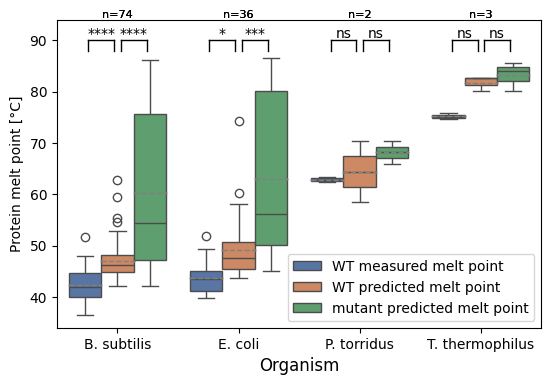

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import os
import pandas as pd

plt.figure(figsize=(6.25, 4))

long_df = pd.melt(Ess_prot_merged, id_vars=['Organism'], value_vars=['meltPoint_x','WT_prediction', 'Mut_prediction'], var_name='Prediction_Type', value_name='Temp_Value')

sns.boxplot(data=long_df, x='Organism', y='Temp_Value', hue='Prediction_Type', palette = 'deep', showmeans = True, meanprops={"marker":".","markerfacecolor":"gray", "markeredgecolor":"gray", "markersize":"1", "color":"gray"}, meanline=True)
new_label = ['B. subtilis', 'E. coli', 'P. torridus', 'T. thermophilus']
plt.ylabel('Protein melt point [°C]', size=10)
plt.xticks(ticks=range(len(new_label)), labels=new_label, rotation=0, size=10)
plt.xlabel('Organism', size=12)
legend = plt.legend(title='', fontsize=10)
new_legend_label = ['WT measured melt point', 'WT predicted melt point', 'mutant predicted melt point']
for text, label in zip(legend.texts, new_legend_label):
    text.set_text(label)



#annotate p-values
hue_order = long_df['Prediction_Type'].unique()
n_hues = len(hue_order)
width = 0.8
spacing = width / n_hues


ax = plt.gca()
y_min, y_max = ax.get_ylim()
y_max +=5
plt.ylim(y_min, y_max)

sample_size = long_df.groupby(['Organism', 'Prediction_Type'])['Temp_Value'].size().unstack()
# Annotate with sample size
ax = plt.gca()
for i, row in sample_size.iterrows():  # Iterate through each organism
    for col, value in row.items():  # Iterate through prediction type within organism
        if not pd.isna(value):  # Check for missing values
            x_pos = i  # X position based on organism index
            #y_pos = ax.get_position().y1  # Get bottom of the plot for annotation placement
            y_pos = y_max - 20
            ax.text(x_pos, y_pos+20, f"n={int(value)}", ha='center', va='bottom', fontsize=8)

for i, org in enumerate(new_label):
    for j, hue in enumerate(hue_order):
        key = f'{hue_order[j-1].split('_')[0]}_{hue.split('_')[0]}'
        if key in p_values.keys():
            p = p_values[key][org]
            p_asterisks = p_to_asterisks(p)
            x = i + j * spacing - width / 2 
            y = y_max - 4
            line = mlines.Line2D([x-spacing/2.5,x+spacing/2.5],[y,y], color='black', linestyle='-', linewidth=1)
            line_v1 = mlines.Line2D([x-spacing/2.5,x-spacing/2.5], [y-2, y], color='black', linestyle='-', linewidth=1)
            line_v2 = mlines.Line2D([x+spacing/2.5,x+spacing/2.5], [y-2, y], color='black', linestyle='-', linewidth=1)


            plt.gca().add_line(line)    
            plt.gca().add_line(line_v1)
            plt.gca().add_line(line_v2)
            plt.text(x, y, p_asterisks, ha='center', va='bottom', fontsize=10)

os.chdir('./data')
plt.savefig('essential_proteins_boxplot.svg', format='svg')
os.chdir('../')
plt.show()

#### Example for ThERMless
The protein P094501_gltR was manually selected, due to its high mutational load.
ThERMless reduces mutations until a certain threshhold is reached (in this case 90 % of original melt point difference)

3D structures of the wild type, original mutant, mutant with reverted catalytical amino acids and reduced mutant were predicted using the AlphaFold 3 server and analysed in PyMol

In [ ]:
from ThERMOS import ThERMless
from SPARC import SPARC

protein_to_analyse = 'P94501_gltR'
selected_row = Ess_prot_merged[Ess_prot_merged['Protein_ID'] == protein_to_analyse]
wt = selected_row['WT_sequence'].iloc[0]
mut = selected_row['Mut_sequence'].iloc[0]
wt_temp = selected_row['WT_prediction'].iloc[0]
mut_temp = selected_row['Mut_prediction'].iloc[0]

red_mut = ThERMless(mut_temp, wt_temp, wt, mut, name = protein_to_analyse, cutoff= 0.9)

#Analyse results of mutation_decreaser
red_seq = red_mut[0]
reduced_mut = []
for i in range(len(red_seq)):
    if red_seq[i] != mut[i]:
        reduced_mut.append(i+1)
print(f'Mutations reverted: {reduced_mut}')
print(f'Number of reverted mutations {len(reduced_mut)}')
print(f'New amino acid sequence {red_seq}')

red_mut_list = []
for i in range(len(wt)):
    if wt[i] != red_seq[i]:
        red_mut_list.append(i+1)
        
print(f'Mutation position formatted for resi selection in pymol{'+'.join([str(x) for x in red_mut_list])}')


#Calculate new temperature
wt_pred = 45.76974259982553 # predicted wild type melt point
mut_pred = 84.11407590083442 # predicted original mutant melt point
mP = 44.6681154920215 # measured melt point
#mutant with reverted acive center amino acids, new mutant after reducing the number of mutations and reverting active center amino acids
mut_az = 'MNIQLLQVFLTAAREGSISKAALTLNYAQSNVTNKIQQLENDLETKLFYRHSRGIALTPPGELLVAYSEKILHTIEEARAARGESSARSGPLRLGARETAAAVWLPQLLAHYNNLYPNVDLNLVTGPTEQEIEAVLHYELNGAFIPGPLEHPDLVEEKVLDEEMVLVRPAPHPVLPPLEDVRARRKLVFRKGCNYRARLNHLLREEGLLPLKLMEFGLLEALLGCVNARLGNNLLPRNNNASHEKEARNRYHRNYDKYYFVARMFVRRKDRLVRPARWAFLRHMRDHFRVKRPARW'
new_mut = 'MNIQLLQVFLTAAREGSISKAALTLNYAQSNVTNKIQQLENDLETKLFYRHSRGIALTPPGELLVAYSEKILHTIEEARAAMGESSAPSGPLRLGAMETAAAVWLPQLLAHYNNLYPNVDLNLVTGPTEQEIEAVLHYELNGAFIPGPLEHPDLVEEKVLDEEMVLVTPAPHPVLPPLEDVQAQTKLVFRKGCNYRARLNHLLQEEGLLPLKLMEFGLLEALLGCVNAGLGNNLLPRNNNASHEKEARNRYHTNYDKYYFVATMFVRRKDTLVTPALWAFLTHMRDHFQVKRPARW'

az_temp = SPARC(mut_az, 'az', './data', './data/s4pred')[0][0]
new_temp = SPARC(new_mut, 'new', './data', './data/s4pred')[0][0]

print(f'Temperature mut_az:  {az_temp}')
print(f'Temperature new_mut: {new_temp}')